(00-backprop)=
# Backpropagation

In this notebook, we look at the **backpropagation algorithm** for efficient gradient computation on computational graphs. Backpropagation involves local message passing of outputs in the forward pass, and gradients in the backward pass. The resulting time complexity is linear in the number of size of the network, i.e. the total number of weights and neurons for neural networks. Neural networks are computational graphs with nodes for differentiable operations. This fact allows scaling training large neural networks. We will implement a minimal scalar-valued **autograd engine** and a neural net library on top it to train a small regression model.

## BP on computational graphs

A neural network can be modelled as a **directed acyclic graph** (DAG) of nodes that implements a function $f$, i.e. all computation flows from an input $\boldsymbol{\mathsf{x}}$ to an output node $f(\boldsymbol{\mathsf{x}})$ with no cycles. 
During training, this is extended to implement the calculation of the loss.
Recall that our goal is to obtain parameter node values $\hat{\boldsymbol{\Theta}}$ after optimization (e.g. with SGD) such that the $f_{\hat{\boldsymbol{\Theta}}}$ minimizes the expected value of a loss function $\ell.$ Backpropagation allows us to efficiently compute $\nabla_{\boldsymbol{\Theta}} \ell$ for SGD after $(\boldsymbol{\mathsf{x}}, y) \in \mathcal{B}$ is passed to the input nodes.

```{figure} ../../../img/nn/03-comp-graph.png
---
width: 80%
name: compute
---
Computational graph of a dense layer. Note that parameter nodes (yellow) always have zero fan-in.
```

**Forward pass.** Forward pass computes $f_{\boldsymbol{\Theta}}(\boldsymbol{\mathsf{x}}).$ All compute nodes are executed starting from the input nodes (which evaluates to the input vector $\boldsymbol{\mathsf x}$). This passed to its child nodes, and so on up to the loss node. The output value of each node is stored to avoid recomputation for child nodes that depend on the same node. This also preserves the network state for backward pass. Finally, forward pass builds the computational graph which is stored in memory. It follows that forward pass for one input is roughly $O(E)$ in time and memory where $E$ is the number of edges of the graph.

**Backward pass.** Backward computes gradients starting from the loss node $\ell$ down 
to the input nodes $\boldsymbol{\mathsf{x}}.$ 
The gradient of $\ell$ with respect to itself is $1$. This serves as the base step.
For any other node $u$ in the graph, we can assume that the **global gradient**
${\partial \ell}/{\partial v}$ is cached for each node $v \in N_u$, where $N_u$ are all nodes 
in the graph that depend on $u$. On the other hand, the **local gradient**
${\partial v}/{\partial u}$ between adjacent nodes is specified 
analytically based on the functional
dependence of $v$ upon $u.$ These are computed at runtime given current node values
cached during forward pass.

The global gradient with respect to node $u$ can then be inductively calculated using the chain 
rule:

$$
\frac{\partial \ell}{\partial u} = \sum_{v \in N_u} \frac{\partial \ell}{\partial v} \frac{\partial v}{\partial u}.
$$

This can be visualized as gradients flowing from the loss node to each network node. 
The flow of gradients will end on parameter and input nodes which depend on no other
nodes. These are called **leaf nodes**. It follows that the algorithm terminates.

```{figure} ../../../img/backward-1.svg
---
width: 80%
name: backward-1
---
Computing the global gradient for a single node. Note that gradient type is distinguished by color: **local** (red) and **global** (blue).
```

This can be visualized as gradients flowing to each network node from the loss node. The flow of gradients will end on parameter and input nodes which have zero fan-in. Global gradients are stored in each compute node in the `grad` attribute for use by the next layer, along with node values obtained during forward pass which are used in local gradient computation. Memory can be released after the weights are updated. On the other hand, there is no need to store local gradients as these are computed as needed. Backward pass can be implemented roughly as follows:

```python
class Node:
    ...

    def comp_graph(self):
        """Return toposorted comp graph with self as root."""
        ...

    def backward(self):
        self.grad = 1.0
        for node in self.comp_graph():
            for parent in node._parents:
                parent.grad += node.grad * node._local_grad(parent)

```

Each node has to wait for all incoming gradients from dependent nodes before passing the gradient to its parents. This is done by topologically sorting the nodes based on dependency with `self` as root (i.e. the node calling `backward` is always treated as the terminal node). 
The contributions of each child node are then accumulated based on the chain rule, where
`node.grad` is the global gradient which is equal to `∂self / ∂node`, while the local gradient `node._local_grad(parent)` is equal to `∂node / ∂parent`. By construction, each child node occurs before any of its parent nodes, thus the full gradient of a child node is calculated before it is sent to its parent nodes ({numref}`03-parent-child-nodes`).

```{figure} ../../../img/nn/03-parent-child-nodes.png
---
width: 100%
name: 03-parent-child-nodes
---
Equivalent ways of computing the global gradient. On the left, the global gradient is computed by tracking the dependencies from $u$ to each of its child node during forward pass. This is our formal statement before. Algorithmically, we start from each node in the upper layer, and we contribute one term in the sum to each parent node. Eventually, all terms in the chain rule is accumulated and the parent node fires, sending gradients to its parent nodes in the previous layer.
```

To construct the topologically sorted list of nodes from a terminal node, we use [depth-first search](https://www.geeksforgeeks.org/topological-sorting/). The following example is shown in {numref}`00-toposort`:

In [1]:
parents = {
    "a": [],
    "b": [],
    "c": ["a", "b"],
    "d": ["c"],
    "e": ["c"],
    "f": ["d"]
}

def comp_graph(self):
    """Return toposorted comp graph with self as root."""
    topo = []
    visited = set()
    def dfs(node):
        if node not in visited:
            visited.add(node)
            for parent in parents[node]:
                dfs(parent)
            topo.append(node)
    dfs(self)
    return reversed(topo)

list(comp_graph("f"))

['f', 'd', 'c', 'b', 'a']

```{figure} ../../../img/nn/00-toposort.png
---
width: 100%
name: 00-toposort
---
Graph encoded in the `parents` dictionary above. Note `d` which `f` has no dependence on is excluded.
Visited nodes (shaded in red) starts from the terminal node backwards into the graph. Then, the nodes are pushed forwards once all leaf nodes (no parents) are visited.
```

<br>

## Properties of backpropagation

Some characteristics of backprop which explains why it is ubiquitous in deep learning:

* **Modularity.** Backprop is a useful tool for reasoning about gradient flow and can suggest ways to improve training or network design. Moreover, since it only requires local gradients between nodes, it allows modularity when designing deep neural networks. 
In other words, we can (in principle) arbitrarily connect layers of computation.

* **Runtime.** Each edge is the DAG is passed exactly once ({numref}`03-parent-child-nodes`). Hence, the time complexity for finding global gradients is $O(n_\mathsf{E})$ where $n_\mathsf{E}$ is the number of edges in the graph, where we assume that each compute node and local gradient evaluation is constant time. For fully-connected networks, $n_\mathsf{E} = n_\mathsf{M} + n_\mathsf{V}$ where $n_\mathsf{M}$ is the number of weights and $n_\mathsf{V}$ is the number of activations. It follows that one backward pass for an instance is proportional to the network size.

* **Memory.** Each training step naively requires $O(2 n_\mathsf{E})$ memory since we store both gradients and values. This can be improved by releasing the gradients and activations of non-leaf nodes in the previous layer once a layer finishes computing its gradient. 

* **GPU parallelism.** Note that forward computation can generally be parallelized in the batch dimension and often times in the layer dimension. This can leverage massive parallelism in the GPU significantly decreasing runtime by trading off memory. The same is true for backward pass which can also be expressed in terms of matrix multiplications! {eq}`backprop-output`

<br>

## References

- {cite}`timviera`
- {cite}`backprop-offconvex`
- {cite}`pytorch-autograd`
- {cite}`micrograd`

## Appendix: Testing with `autograd`

The `autograd` package allows automatic differentiation by building computational graphs on the fly every time we pass data through our model. Autograd tracks which data combined through which operations to produce the output. This allows us to take derivatives over ordinary imperative code. This functionality is consistent with the memory and time requirements outlined above for BP.

**Scalars.** Here we calculate $\mathsf{y} = \boldsymbol{\mathsf x}^\top \boldsymbol{\mathsf x} = \sum_i {\boldsymbol{\mathsf{x}}_i}^2$ where the initialized tensor $\boldsymbol{\mathsf{x}}$ initially has no gradient (i.e. `None`). Calling backward on $\mathsf{y}$ results in gradients being stored on the leaf tensor $\boldsymbol{\mathsf{x}}.$ Note that unlike our implementation, there is no need to set `y.grad = 1.0`. Moreover, doing so would result in an error as $\mathsf{y}$ is not a [leaf node](https://pytorch.org/docs/stable/generated/torch.Tensor.is_leaf.html) in the graph.

In [2]:
import torch
import torch.nn.functional as F
print(torch.__version__)

2.2.2


In [3]:
x = torch.arange(4, dtype=torch.float, requires_grad=True)
print(x.grad)

y = x.reshape(1, -1) @ x 
y.backward() 
print((x.grad == 2*x).all().item())

None
True


**Vectors.** Let $\boldsymbol{\mathsf y} = g(\boldsymbol{\mathsf x})$ and let $\boldsymbol{{\mathsf v}}$ be a vector having the same length as $\boldsymbol{\mathsf y}.$ Then `y.backward(v)` calculates
$\sum_i {\boldsymbol{\mathsf v}}_i \frac{\partial {\boldsymbol{\mathsf y}}_i}{\partial {\boldsymbol{\mathsf x}}_j}$
resulting in a vector of same length as $\boldsymbol{\mathsf{x}}$ stored in `x.grad`. Note that the terms on the right are the local gradients. Setting ${\boldsymbol{\mathsf v}} = \frac{\partial \mathcal{L} }{\partial \boldsymbol{\mathsf y}}$ gives us the vector $\frac{\partial \mathcal{L} }{\partial \boldsymbol{\mathsf x}}.$ Below $\boldsymbol{\mathsf y}(\boldsymbol{\mathsf x}) = [x_0, x_1].$

In [4]:
x = torch.rand(size=(4,), dtype=torch.float, requires_grad=True)
v = torch.rand(size=(2,), dtype=torch.float)
y = x[:2]

# Computing the Jacobian by hand
J = torch.tensor([
    [1, 0, 0, 0],
    [0, 1, 0, 0]], dtype=torch.float
)

# Confirming the above formula
y.backward(v)
(x.grad == v @ J).all()

tensor(True)

**Remark.** Memory and compute is wasted for running code that should not involve backpropagation. Hence, we wrap this part our code in a `torch.no_grad()` context (or run it inside a function decorated with `@torch.no_grad()`) so that a computation graph is not built. 

A related method is `.detach()` used to return a tensor detached from the current graph. The result will therefore not require gradients. It is important to note that the detached tensor still shares the same storage with the original one, so that in-place modifications on either tensor takes effect for both and can result in subtle bugs.

### Testing

Finally, we write our tests with `autograd` to check the correctness of our implementation:

In [5]:
x = Node(-4.0)
z = Node(2) * x + Node(2) - x
q = z.relu() + z * x.tanh()
h = (z * z).relu()
y = (-h + q + q * x).tanh()
y.grad = 1.0
y.backward()

x_node, y_node, z_node = x, y, z
draw_graph(y_node)

NameError: name 'Node' is not defined

In [ ]:
x = torch.tensor(-4.0, requires_grad=True)
z = 2 * x + 2 - x
q = z.relu() + z * x.tanh()
h = (z * z).relu()
y = (-h + q + q * x).tanh()

z.retain_grad()
y.retain_grad()
y.backward()

x_torch, y_torch, z_torch = x, y, z

# forward
errors = []
errors.append(abs(x_node.data - x_torch.item()))
errors.append(abs(y_node.data - y_torch.item()))
errors.append(abs(z_node.data - z_torch.item()))

# backward
errors.append(abs(x_node.grad - x_torch.grad.item()))
errors.append(abs(y_node.grad - y_torch.grad.item()))
errors.append(abs(z_node.grad - z_torch.grad.item()))

print(f"Max absolute error: {max(errors):.2e}")

Max absolute error: 7.48e-08


(00-backprop:appendix-backpropagation-equations-for-mlps)=
## Appendix: BP equations for MLPs

Closed-form expressions for input and output gradients 
is more efficient to compute since 
no explicit passing of gradients between nodes is performed.
Moreover, such expressions allow us to see how to express it in terms of matrix 
operations which are computed in parallel.
In this section, we derive BP equations specifically for MLPs.
Recall that a dense layer with weights $\boldsymbol{\mathsf{w}}_j \in \mathbb{R}^d$ 
and bias ${b}_j \in \mathbb{R}$ computes given an input $\boldsymbol{\mathsf{x}} \in \mathbb{R}^d$
the following equations for $j = 1, \ldots, h$ where $h$ is the layer width:
```{math}
:label: fully-connected-layer
\begin{aligned}
    z_j &= \boldsymbol{\mathsf{x}} \cdot \boldsymbol{\mathsf{w}}_j + {b}_j \\
    y_j &= \phi\left( z_j \right) \\
\end{aligned}
```
Given global gradients 
$\partial \ell / \partial y_j$
that flow into the layer, we compute the global gradients of the nodes 
$\boldsymbol{\mathsf{z}}$, $\boldsymbol{\mathsf{w}}$, $\boldsymbol{\mathsf{b}}$, and $\boldsymbol{\mathsf{x}}$
in the layer. 
As discussed above, this can be done by tracking backward dependencies in 
the computational graph ({numref}`fully-connected-backprop.drawio`).


```{figure} ../../img/fully-connected-backprop.drawio.svg
---
name: fully-connected-backprop.drawio
width: 50%
---
Node dependencies in compute nodes of a fully connected layer. All nodes $\boldsymbol{\mathsf{z}}_k$ depend on the node $\boldsymbol{\mathsf{y}}_j.$
```


Note that there can be cross-dependencies for activations such as softmax. 
For typical activations $\phi,$ the [Jacobian](https://mathworld.wolfram.com/Jacobian.html)
$\mathsf{J}^{\phi}_{kj} = \frac{\partial y_k}{\partial z_j}$ 
reduces to a diagonal matrix. Following backward dependencies 
for the compute nodes:

```{math}
\begin{align}
\frac{\partial \ell}{\partial {z}_j} &= \sum_k \frac{\partial \ell}{\partial {y}_k}  \frac{\partial {y}_k}{\partial {z}_j} =  \sum_k \frac{\partial \ell}{\partial {y}_k} \mathsf{J}^{\phi}_{kj} \\
\frac{\partial \ell}{\partial {x}_i} &= \sum_j \frac{\partial \ell}{\partial {z}_j} \frac{\partial {z}_j}{\partial {x}_i} = \sum_j \frac{\partial \ell}{\partial {z}_j} {w}_{ij} = \sum_j \frac{\partial \ell}{\partial {z}_j} {w}_{ji}^{\top}.
\end{align}
```

Note that the second equation uses the gradients calculated in the first equation. Next, we compute gradients for the weights:

```{math}
\begin{align}
\frac{\partial \ell}{\partial{w}_{ij}} 
&= \frac{\partial \ell}{\partial{z}_{j}} \frac{\partial{z}_{j}}{\partial{w}_{ij}} 
= {x}_{i} \frac{\partial \ell}{\partial{z}_{j}} \label{eq:gradient_weight} \\
\frac{\partial \ell}{\partial{b}_{j}} 
&= \frac{\partial \ell}{\partial{z}_{j}}  \frac{\partial{z}_{j}} {\partial{b}_{j}} 
= \frac{\partial \ell}{\partial{z}_{j}}. \label{eq:gradient_bias}
\end{align}
```

Observe the dependence of the weight gradient on the input makes it sensitive to scaling.
This can introduce an effective scalar factor to the learning rate that is specific to 
each input dimension, making SGD diverge at early stages of training. This motivates
network input normalization and layer output normalization.

### Batch computation

Let $B$ be the batch size. Processing a batch of inputs in parallel, in principle, creates a graph 
consisting of $B$ copies of the original computational graph that share the same parameters. 
The outputs of these combine to form the loss node $\mathcal{L} = \frac{1}{B}\sum_b \ell_b.$ For usual activations, $\boldsymbol{\mathsf{J}}^\phi = \text{diag}(\phi^\prime(\boldsymbol{\mathsf{z}}))$. The output and input gradients can be written in the following matrix notation for fast computation:

```{math}
:label: backprop-output
\begin{aligned}
\frac{\partial \mathcal{L}}{\partial \boldsymbol{\mathsf{Z}}} &= \frac{\partial \mathcal{L}}{\partial \boldsymbol{\mathsf{Y}}} \odot {\phi}^{\prime}(\boldsymbol{\mathsf{Z}})
\end{aligned}
```

```{math}
:label: backprop-input
\begin{aligned}
\frac{\partial \mathcal{L}}{\partial \boldsymbol{\mathsf{X}}} &= \frac{\partial \mathcal{L}}{\partial \boldsymbol{\mathsf{Z}}}\, \boldsymbol{\mathsf{W}}^\top \hspace{18pt}
\end{aligned}
```

These correspond to the equations above since there is no dependence across batch instances. Note that the stacked output tensors $\boldsymbol{\mathsf{Z}}$ and $\boldsymbol{\mathsf{Y}}$ have shape $(B, h)$ where $h$ is the layer width and $B$ is the batch size. The stacked input tensor $\boldsymbol{\mathsf{X}}$ has shape $(B, d)$ where $d$ is the input dimension. Finally, the weight tensor $\boldsymbol{\mathsf{W}}$ has shape $(d, h).$ For the weights, the contribution of the entire batch have to be accumulated ({numref}`weight-backprop.drawio`):

```{math}
:label: backprop-weights
\begin{align}
\frac{\partial \mathcal{L}}{\partial{\boldsymbol{\mathsf{W}}}} 
= \boldsymbol{\mathsf{X}}^\top \frac{\partial \mathcal{L}}{\partial \boldsymbol{\mathsf{Z}}}. \hspace{30pt}
\end{align}
```

```{math}
:label: backprop-bias
\begin{align}
\frac{\partial \mathcal{L}}{\partial{\boldsymbol{\mathsf{b}}}} 
= [1, \ldots, 1] \, \frac{\partial \mathcal{L}}{\partial \boldsymbol{\mathsf{Z}}}.
\end{align}
```

**Remark.** One way to remember these equations is that the shapes must check out.

<br>

```{figure} ../../img/weight-backprop.drawio.svg
---
name: weight-backprop.drawio
width: 30%
---
Node dependencies for a weight node. The nodes $\boldsymbol{\mathsf{z}}_{bj}$ depend on $\boldsymbol{\mathsf{w}}_{ij}$ for $b = 1, \ldots, B.$
```

### Cross entropy

In this section, we compute the gradient across the **cross-entropy loss**.
This can be calculated using backpropagation, but we will derive it 
symbolically to get a closed-form formula. Recall that cross-entropy loss computes
for logits $\boldsymbol{\mathsf{s}}$:

$$
\begin{aligned}
\ell 
&= -\log \frac{\exp({s_{y}})}{\sum_{k=1}^m \exp({{s}_{k}})} \\
&= - s_{y} + \log \sum_{k=1}^m \exp({s_k}).
\end{aligned}
$$

Calculating the derivatives, we get

$$
\begin{aligned}
\frac{\partial \ell}{\partial s_j} 
&= - \delta_{j}^y + \frac{\exp({s_j})}{\sum_{k=1}^m \exp({s_k})} \\ \\
&= - \delta_{j}^y + \text{softmax}(s_j) = 
\left\{
\begin{array}{l}
p_j \quad \quad\;\;\; \text{if $\;j \neq y$}\\
p_y - 1 \quad \text{else}\\
\end{array}
\right.
\end{aligned}
$$

where $\delta_{j}^y$ is the [Kronecker delta](https://en.wikipedia.org/wiki/Kronecker_delta).
This makes sense: having output values in nodes that do not correspond 
to the true class only contributes to increasing the loss. This effect is particularly strong 
when the model is confidently wrong such that $p_y \approx 0$ on the true class and
$p_{j^*} \approx 1$ where $j^* = \text{arg max}_j\, s_j$
is the predicted wrong class.
On the other hand,
increasing values in the node for the true class results in decreasing loss for all nodes.
In this case, 
$\text{softmax}(\boldsymbol{\mathsf{s}}) \approx \mathbf{1}_y,$ and
${\partial \ell}/{\partial \boldsymbol{\mathsf{s}}}$ becomes close to the zero vector, 
so that $\nabla_{\boldsymbol{\Theta}} \ell$ is also close to zero.

The gradient of the logits ${\boldsymbol{\mathsf{S}}}$ can be written in matrix form
where $\mathcal{L} = \frac{1}{B}\sum_b \ell_b$:

```{math}
:label: backprop-cross-entropy
\begin{aligned}
\frac{\partial \mathcal{L}}{\partial {\boldsymbol{\mathsf{S}}}} 
&= - \frac{1}{B} \left( \boldsymbol{\delta} - \text{softmax}({\boldsymbol{\mathsf{S}}}) \right).
\end{aligned}
```

**Remark.** Examples with similar features but different labels can contribute to a smoothing between 
the labels of the predicted probability vector. This is nice since we can use the probability
value as a measure of confidence. We should also expect a noisy loss curve in the presence of significant label noise.

### Gradient checking

Computing the cross-entropy for a batch:

In [ ]:
B = 32
N = 27

# forward pass
t = torch.randint(low=0, high=N, size=(B,))
x = torch.randn(B, 128, requires_grad=True)
w = torch.randn(128, N, requires_grad=True)
b = torch.randn(N,      requires_grad=True)
z = x @ w + b
y = torch.tanh(z)

for node in [x, w, b, z, y]:
    node.retain_grad()

# backprop batch loss
loss = -torch.log(F.softmax(y, dim=1)[range(B), t]).sum() / B
loss.backward()

Plotting the gradient of the logits:

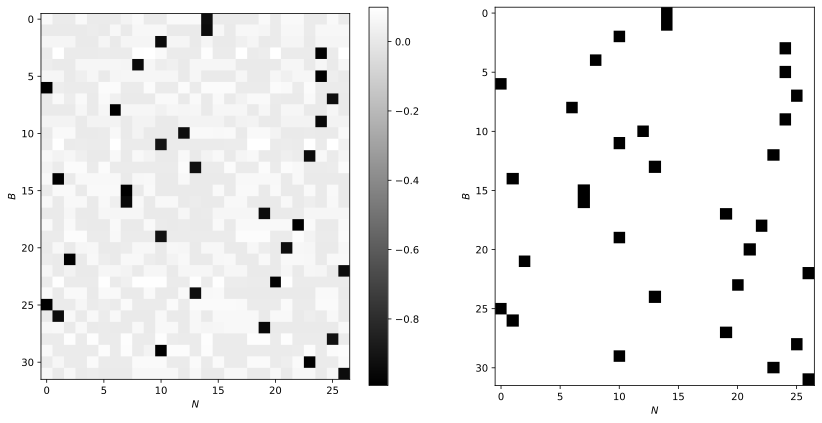

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
c = ax[0].imshow(y.grad.detach().numpy() * B, cmap='gray')
ax[1].imshow(-F.one_hot(t, num_classes=N).detach().numpy(), cmap='gray')
ax[0].set_ylabel("$B$")
ax[1].set_ylabel("$B$")
ax[0].set_xlabel("$N$")
ax[1].set_xlabel("$N$")
plt.colorbar(c, ax=ax[0])
fig.tight_layout();

**Figure.** Gradient of the logits for given batch (left) and actual targets (right). Notice the sharp contribution to decreasing loss by increasing the logit of the correct class. Other nodes contribute to increasing the loss. It's hard to see, but incorrect pixels have positive values that sum to the pixel value in the target. Checking this to ensure correctness:

In [ ]:
y.grad.sum(dim=1, keepdim=True).abs().mean()

tensor(2.0609e-09)

Recall that the above equations were vectorized with the convention that the gradient with respect to a tensor $\boldsymbol{\mathsf{v}}$ has the same shape as $\boldsymbol{\mathsf{v}}.$ In PyTorch, `v.grad` is the global gradient with respect to `v` of the tensor that called `.backward()` (i.e. `loss` in our case). The following computation should give us an intuition of how gradients flow backwards through the neural net starting from the loss to all intermediate results:

In [ ]:
J = 1 - y**2                                    # Jacobian
δ_tk = F.one_hot(t, num_classes=N)              # Kronecker delta
dy = - (1 / B) * (δ_tk - F.softmax(y, dim=1))   # logits grad
dz = dy * J
dx = dz @ w.T
dw = x.T @ dz
db = dz.sum(0, keepdim=True)

Refer to {eq}`backprop-cross-entropy`, {eq}`backprop-output`, {eq}`backprop-input`, {eq}`backprop-weights`, and {eq}`backprop-bias` above. These equations can be checked using `autograd` as follows:

In [ ]:
def compare(name, dt, t):
    exact  = torch.all(dt == t.grad).item()
    approx = torch.allclose(dt, t.grad, rtol=1e-5)
    maxdiff = (dt - t.grad).abs().max().item()
    print(f'{name:<3s} | exact: {str(exact):5s} | approx: {str(approx):5s} | maxdiff: {maxdiff:.2e}')


compare('y', dy, y)
compare('z', dz, z)
compare('x', dx, x)
compare('w', dw, w)
compare('b', db, b)

y   | exact: False | approx: True  | maxdiff: 1.86e-09
z   | exact: False | approx: True  | maxdiff: 1.16e-10
x   | exact: False | approx: True  | maxdiff: 1.86e-09
w   | exact: False | approx: True  | maxdiff: 1.86e-09
b   | exact: False | approx: True  | maxdiff: 2.33e-10


---

■